# This notebook aims to test hypotheses of interest for deeper analysis

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import colors as mcolors
import seaborn
seaborn.set()

Reading data

In [106]:
users = pd.read_csv('Data/userlist_filt.csv')
userlists = pd.read_csv('Data/userAnimeList_filt.csv')

In [107]:
animes = pd.read_csv('Data/animelist_filt.csv')

## The first hypothesis we are going to test: Do female users watch more romance shows?
H0: mean(male) >= mean(female);
H1: mean(male) < mean(female)

In [108]:
userlists = pd.merge(
    pd.merge(userlists,users[['username','gender','stats_episodes']], on='username',how='left'),
    animes[['anime_id','Romance']], on='anime_id',how='left'
)
ratings_by_gender = userlists.groupby(['username','gender']).agg(count=('username','count'))
ratings_by_gender = ratings_by_gender.groupby('gender').agg(mean=('count','mean'))

Counting the amount of romance shows watched and adjusting by the mean

In [109]:
counts = userlists.groupby(['username']).agg({'Romance':'sum','stats_episodes': 'first','gender':'first'})
counts = counts[counts['stats_episodes'] != 0]
counts = pd.merge(counts, ratings_by_gender, on='gender')
counts['Romance'] = counts['Romance'] / counts['mean']

Plotting

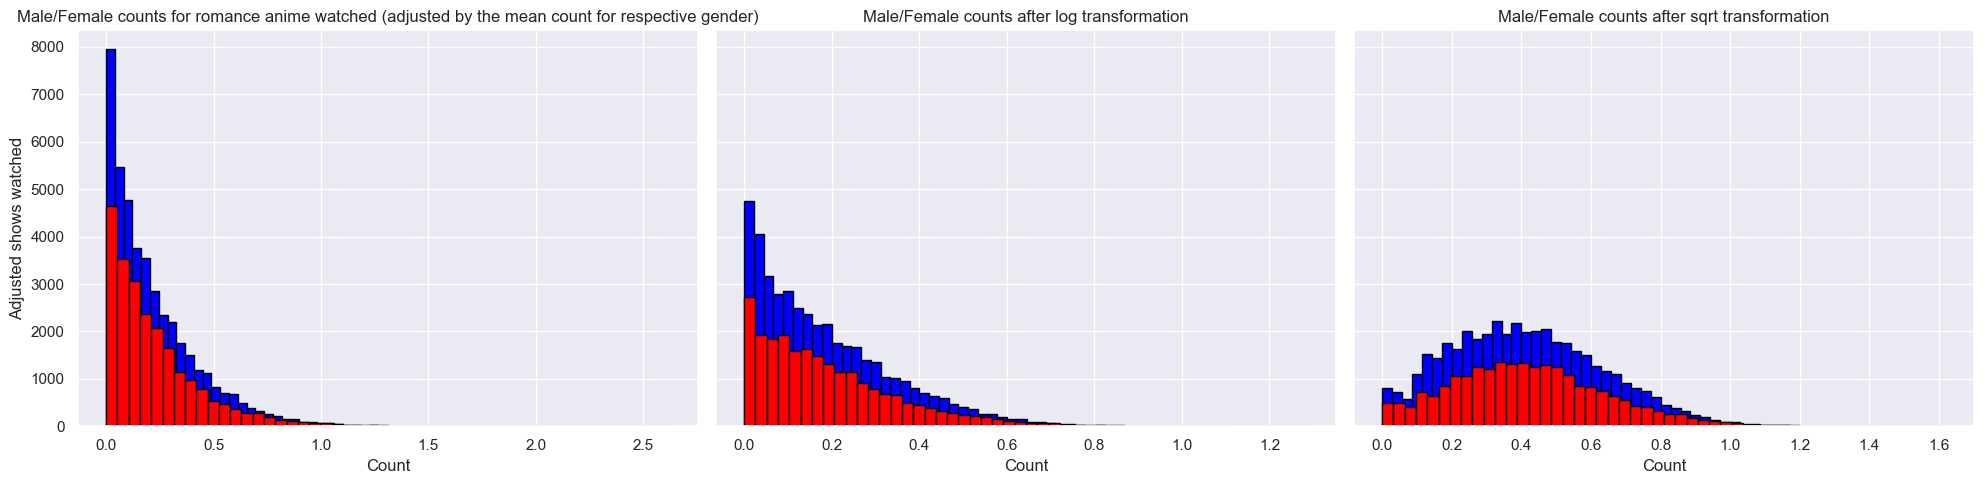

In [110]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5), sharey='row')
ax1.hist(counts[counts['gender'] == 'Male'].Romance, bins=50,color='blue',edgecolor='black',)
ax1.hist(counts[counts['gender'] == 'Female'].Romance, bins=50,color='red',edgecolor='black',)
ax1.set_title("Male/Female counts for romance anime watched (adjusted by the mean count for respective gender)")
ax1.set_xlabel('Count')
ax1.set_ylabel('Adjusted shows watched')

counts['Romance_log'] = np.log(counts['Romance']+1)
ax2.hist(counts[counts['gender'] == 'Male'].Romance_log, bins=50,color='blue',edgecolor='black',)
ax2.hist(counts[counts['gender'] == 'Female'].Romance_log, bins=50,color='red',edgecolor='black',)
ax2.set_title("Male/Female counts after log transformation")
ax2.set_xlabel('Count')

counts['Romance_sqrt'] = np.sqrt(counts['Romance'])
ax3.hist(counts[counts['gender'] == 'Male'].Romance_sqrt, bins=50,color='blue',edgecolor='black',)
ax3.hist(counts[counts['gender'] == 'Female'].Romance_sqrt, bins=50,color='red',edgecolor='black',)
ax3.set_title("Male/Female counts after sqrt transformation")
ax3.set_xlabel('Count')

plt.tight_layout()
plt.show()

As we can see, in order to test the hypothesis, we need to transform the data. Square root transformation seems to do well

In [115]:
statistic, p_value = stats.ttest_ind(counts[counts['gender'] == 'Male'].Romance_sqrt,counts[counts['gender'] == 'Female'].Romance_sqrt, equal_var=False)

print(f'T-test p-value: {p_value}')
print(f'T-statistic: {statistic}')
u_statistic, p_value = stats.mannwhitneyu(counts[counts['gender'] == 'Male'].Romance_sqrt, counts[counts['gender'] == 'Female'].Romance_sqrt, alternative='two-sided')
print(f'Mann-whitney P-value: {p_value}')

T-test p-value: 2.1514250368253008e-07
T-statistic: -5.1865368700173615
Mann-whitney P-value: 9.856001275620035e-06


With these results, we can conclude that there is a significant difference between the amount of romance shows watched by male and female users with the negative t-statistic indicating that female users have a higher mean

# The second hypothesis we are going to test comes from the data exploration notebook: Is there a relationship between having zero mean rating and having no episodes watched?
This could be the case for some users to intentionally disrupt ratings by creating throwaway accounts.

In [112]:
zerolists = users[['username','stats_episodes','stats_mean_score']]
zerolists = zerolists[zerolists['stats_mean_score'] == 0]
zerolists_zero_episodes = zerolists[zerolists['stats_episodes'] == 0]

In [113]:
total_zero_mean = len(zerolists)
zero_mean_zero_episodes = len(zerolists_zero_episodes)
zero_mean_non_zero_episodes = total_zero_mean - zero_mean_zero_episodes

contingency_table = pd.DataFrame({
    'Zero Episodes': [zero_mean_zero_episodes, len(users) - total_zero_mean],
    'Non-Zero Episodes': [zero_mean_non_zero_episodes, len(users) - len(zerolists)]
}, index=['Zero Mean Score', 'Other'])

contingency_table

,Zero Episodes,Non-Zero Episodes
Zero Mean Score,1704,1530
Other,65050,65050


In [114]:
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(f'Chi-squared Statistic: {chi2}')
print(f'P-value: {p_value}')

Chi-squared Statistic: 9.02743780716443
P-value: 0.002659569997732601


The p-value indicates that there is a very significant relationship between having zero episodes watched and having zero mean rating